In [71]:
import pandas as pd
import wbdata
import datetime
import os
import matplotlib.pyplot as plt
os.chdir("C:/Users/chris/Documents/EPA/Economics of cyber security/Data analysis project/econ_sec-master")

## Test Data
Importing tests of CAIDA and calculating percentage scores of countries in their mitigation of IP-spoofing

In [41]:
test_df = pd.read_csv("recent_tests.csv", sep=';', dtype={'Sesssion': 'str'})

#Resetting types
test_df.astype({'Timestamp': 'str',
                'Client IP Block': 'str',
                'ASN': 'str', 
                'Country': 'str', 
                'NAT': 'str', 
                'Outbound Private Status': 'str',
               'Adjacent Spoof Prefix Length': 'str'}).dtypes

df_blocked = test_df.loc[test_df['Outbound Routable Status'] == 'blocked']
df_received = test_df.loc[test_df['Outbound Routable Status'] == 'received']

In [49]:
def column_percentage(df1, df2, column, threshold=0):
    blocked_countries = df1[column].unique().tolist()
    received_countries = df2[column].unique().tolist()
    
    country_list = []
    percentages = []
    
    for val in received_countries:
        received_country_df = df2.loc[df2[column] == val]
        if val in blocked_countries:
            blocked_country_df = df1.loc[df1[column] == val]
            
            if received_country_df.shape[0] > threshold:
                percentage = round((received_country_df.shape[0]/(blocked_country_df.shape[0] + received_country_df.shape[0])) *100, 2)
                percentages.append(percentage)
                
                country_list.append(val)
            
        else:
            if received_country_df.shape[0] > threshold:
                percentages.append(100)
                country_list.append(val)
        
    return pd.DataFrame({'Percentage mitigation':percentages}, index=country_list)
        
df_percentages = column_percentage(df_blocked, df_received, 'Country')

,Percentage mitigation
"khm (Cambodia, Kingdom of)",86.67
bra (Brazil),31.76
bih (Bosnia and Herzegovina),53.38
can (Canada),5.44
usa (United States),6.23
...,...
aze (Azerbaijan),100.00
phl (Philippines),26.00
irq (Iraq),92.31
mus (Mauritius),50.00


In [65]:
#read worldbank GDP data
data_date = datetime.datetime(2019, 1, 1)
df_GDP = wbdata.get_dataframe({'NY.GDP.MKTP.CD':'GDP'}, country='all', data_date=data_date)

#read IDI scores
df_idi = pd.read_csv("IDI_2017_Rank.csv", sep=';', index_col=1)

,IDI 2017 Rank,IDI 2017 Value
Economy,,
Iceland,1,8.98
Korea (Rep.),2,8.85
Switzerland,3,8.74
Denmark,4,8.71
United Kingdom,5,8.65
...,...,...
Burundi,172,1.48
Guinea-Bissau,173,1.48
Chad,174,1.27


# Merging
Merge the different datasources into one dataframe

In [70]:
for i in df_GDP.index:
    for j in df_percentages.index:
        if i in j:
            df_percentages.loc[j,'GDP'] = df_GDP.loc[i,'GDP']

for i in df_idi.index:
    for j in df_percentages.index:
        if i in j:
            df_percentages.loc[j,'IDI'] = df_idi.loc[i,'IDI 2017 Value']
            
df_percentages = df_percentages.dropna()
df_percentages

C:\Users\chris\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\chris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\chris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

,Percentage mitigation,GDP,IDI
"khm (Cambodia, Kingdom of)",86.67,2.708939e+10,3.28
bra (Brazil),31.76,1.839758e+12,6.12
bih (Bosnia and Herzegovina),53.38,2.004785e+10,5.39
usa (United States),6.23,2.137442e+13,8.18
swe (Sweden),5.77,5.308329e+11,8.41
...,...,...,...
gha (Ghana),100.00,6.698363e+10,4.05
rwa (Rwanda),37.93,1.012247e+10,2.18
aze (Azerbaijan),100.00,4.804765e+10,6.20
phl (Philippines),26.00,3.767955e+11,4.67


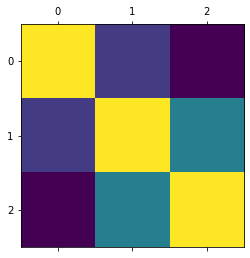

In [73]:
plt.matshow(df_percentages.corr())
plt.show()